In [24]:
!pip install shap --quiet
!pip install shapash --quiet
!pip install shapash[report] --quiet
!pip install shap --quiet
!pip install lime --quiet

  Preparing metadata (setup.py) ... done


In [45]:
from shapash.explainer.smart_explainer import SmartExplainer
from sklearn.datasets import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import numpy as np
from category_encoders import OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from shapash.data.data_loader import data_loading
import shap

In [89]:
house_df, house_dict = data_loading('house_prices')

In [90]:
house_df

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,2-Story 1946 & Newer,Residential Low Density,8450,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,College Creek,...,0,0,0,0,0,2,2008,Warranty Deed - Conventional,Normal Sale,208500
2,1-Story 1946 & Newer All Styles,Residential Low Density,9600,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Frontage on 2 sides of property,Gentle slope,Veenker,...,0,0,0,0,0,5,2007,Warranty Deed - Conventional,Normal Sale,181500
3,2-Story 1946 & Newer,Residential Low Density,11250,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,College Creek,...,0,0,0,0,0,9,2008,Warranty Deed - Conventional,Normal Sale,223500
4,2-Story 1945 & Older,Residential Low Density,9550,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Corner lot,Gentle slope,Crawford,...,272,0,0,0,0,2,2006,Warranty Deed - Conventional,Abnormal Sale,140000
5,2-Story 1946 & Newer,Residential Low Density,14260,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Frontage on 2 sides of property,Gentle slope,Northridge,...,0,0,0,0,0,12,2008,Warranty Deed - Conventional,Normal Sale,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2-Story 1946 & Newer,Residential Low Density,7917,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,Gilbert,...,0,0,0,0,0,8,2007,Warranty Deed - Conventional,Normal Sale,175000
1457,1-Story 1946 & Newer All Styles,Residential Low Density,13175,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,Northwest Ames,...,0,0,0,0,0,2,2010,Warranty Deed - Conventional,Normal Sale,210000
1458,2-Story 1945 & Older,Residential Low Density,9042,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,Crawford,...,0,0,0,0,2500,5,2010,Warranty Deed - Conventional,Normal Sale,266500


In [91]:
house_dict

{'MSSubClass': 'Building Class',
 'MSZoning': 'General zoning classification',
 'LotArea': 'Lot size square feet',
 'Street': 'Type of road access',
 'LotShape': 'General shape of property',
 'LandContour': 'Flatness of the property',
 'Utilities': 'Type of utilities available',
 'LotConfig': 'Lot configuration',
 'LandSlope': 'Slope of property',
 'Neighborhood': 'Physical locations within Ames city limits',
 'Condition1': 'Proximity to various conditions',
 'Condition2': 'Proximity to other various conditions',
 'BldgType': 'Type of dwelling',
 'HouseStyle': 'Style of dwelling',
 'OverallQual': 'Overall material and finish of the house',
 'OverallCond': 'Overall condition of the house',
 'YearBuilt': 'Original construction date',
 'YearRemodAdd': 'Remodel date',
 'RoofStyle': 'Type of roof',
 'RoofMatl': 'Roof material',
 'Exterior1st': 'Exterior covering on house',
 'Exterior2nd': 'Other exterior covering on house',
 'MasVnrType': 'Masonry veneer type',
 'MasVnrArea': 'Masonry venee

In [92]:
y_df=house_df['SalePrice'].to_frame()
X_df=house_df[house_df.columns.difference(['SalePrice'])]

In [93]:
house_df.head()


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,2-Story 1946 & Newer,Residential Low Density,8450,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,College Creek,...,0,0,0,0,0,2,2008,Warranty Deed - Conventional,Normal Sale,208500
2,1-Story 1946 & Newer All Styles,Residential Low Density,9600,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Frontage on 2 sides of property,Gentle slope,Veenker,...,0,0,0,0,0,5,2007,Warranty Deed - Conventional,Normal Sale,181500
3,2-Story 1946 & Newer,Residential Low Density,11250,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,College Creek,...,0,0,0,0,0,9,2008,Warranty Deed - Conventional,Normal Sale,223500
4,2-Story 1945 & Older,Residential Low Density,9550,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Corner lot,Gentle slope,Crawford,...,272,0,0,0,0,2,2006,Warranty Deed - Conventional,Abnormal Sale,140000
5,2-Story 1946 & Newer,Residential Low Density,14260,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Frontage on 2 sides of property,Gentle slope,Northridge,...,0,0,0,0,0,12,2008,Warranty Deed - Conventional,Normal Sale,250000


In [94]:
from category_encoders import OrdinalEncoder

categorical_features = [col for col in X_df.columns if X_df[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_df)

X_df=encoder.transform(X_df)

In [95]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, train_size=0.75, random_state=1)

In [96]:
regressor = LGBMRegressor(n_estimators=100).fit(Xtrain,ytrain)


In [97]:
xpl = SmartExplainer(
    model=regressor,
    preprocessing=encoder,   # Optional: compile step can use inverse_transform method
    features_dict=house_dict # optional parameter, specifies label for features name
)

In [98]:
xpl.compile(x=Xtest,
            y_target=ytest # Optional: allows to display True Values vs Predicted Values
           )

In [99]:
app = xpl.run_app(title_story='House Prices', port=8020)


In [100]:
app

<CustomThread(Thread-10 (<lambda>), stopped 139783060829760)>

In [101]:
app.kill()

In [102]:
summary_df= xpl.to_pandas(
    max_contrib=3, # Number Max of features to show in summary
    threshold=5000,
)

In [103]:
summary_df

,pred,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3
259,209880.263221,Ground living area square feet,1792,13695.285729,Overall material and finish of the house,7,12862.47545,Total square feet of basement area,963,-5157.082948
268,176532.935969,Ground living area square feet,2192,28467.464765,Overall material and finish of the house,5,-26409.133602,Overall condition of the house,8,8859.100865
289,114424.272965,Overall material and finish of the house,5,-24879.968352,Ground living area square feet,900,-16521.128584,Total square feet of basement area,882,-5908.266171
650,74222.217661,Overall material and finish of the house,4,-34505.11735,Ground living area square feet,630,-22299.246168,Total square feet of basement area,630,-11722.276365
1234,137559.671733,Overall material and finish of the house,5,-25713.442341,Ground living area square feet,1188,-11605.41637,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1018,222781.573417,Overall material and finish of the house,8,67276.810491,Ground living area square feet,1360,-10589.771429,Lot size square feet,5814,-8051.92756
535,196841.479988,Overall material and finish of the house,8,56748.906791,Type 1 finished square feet,0,-9772.620658,Size of garage in square feet,403,-8795.436053
1335,128618.464221,Overall material and finish of the house,5,-24666.650727,Lot size square feet,2368,-8416.13555,Ground living area square feet,1365,-8087.979848
1370,228401.071492,Overall material and finish of the house,8,55009.073552,Total square feet of basement area,1657,12220.194668,Ground living area square feet,1668,-7616.120492


In [ ]:
xpl.save('./xpl.pkl')

### Feature Importance.

In [104]:
# feature importance

xpl.plot.features_importance()

### How feature contributes, similar to the partial dependency plot.

In [105]:
xpl.plot.contribution_plot("OverallQual")

In [ ]:
xpl.plot.contribution_plot("Second floor square feet")

### Local Explaination

In [ ]:
xpl.plot.local_plot(index=560)


In [25]:
# disaster tweets in twitter

# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn import metrics
import lime
import sklearn.ensemble
from __future__ import print_function
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

In [26]:
# downloading the nltk data for preprocessing
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [62]:
# downloading the data
data_urls = ['https://raw.githubusercontent.com/KaliaBarkai/KaggleDisasterTweets/master/Data/%s.csv'%ds for ds in ['train', 'test', 'sample_submission']]

# reading the data as pandas dataframe
train_df = pd.read_csv(data_urls[0])
test_df = pd.read_csv(data_urls[1])
sample_submission = pd.read_csv(data_urls[2])

In [63]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [64]:
# NLP pre-processing
# remove urls, handles, and the hashtag from hashtags
# (taken from https://stackoverflow.com/questions/8376691/how-to-remove-hashtag-user-link-of-a-tweet-using-regular-expression)
def remove_urls(text):
  new_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
  return new_text

In [65]:
# make all text lowercase
def text_lowercase(text):
  return text.lower()

In [66]:
# remove numbers
def remove_numbers(text):
  result = re.sub(r'\d+', '', text)
  return result

In [67]:
# remove punctuation
def remove_punctuation(text):
  translator = str.maketrans('', '', string.punctuation)
  return text.translate(translator)

In [68]:
# function for all pre-processing steps
def preprocessing(text):
  text = text_lowercase(text)
  text = remove_urls(text)
  text = remove_numbers(text)
  text = remove_punctuation(text)
  return text

In [69]:
# pre-processing the text body column
pp_text = []
for text_data in train['text']:
  # check if string
  if isinstance(text_data, str):
    pp_text_data = preprocessing(text_data)
    pp_text.append(pp_text_data)
   # if not string
  else:
    pp_text.append(np.NaN)

In [70]:
# add pre-processed column to dataset
train_df['pp_text'] = pp_text

In [71]:
# split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(train_df["pp_text"], train_df["target"])

In [122]:
# create bag-of-words with weights using tfid vectoriser
# strip accents and remove stop words during vectorisation
tfidf_vec = TfidfVectorizer(strip_accents = 'ascii', stop_words='english')

In [128]:
# transform and fit the training set with vectoriser
train_X_tfidf = tfidf_vec.fit_transform(train_X)
# transform the test set with vectoriser
test_X_tfidf = tfidf_vec.transform(test_X)


In [129]:
train_X_tfidf

<5709x11851 sparse matrix of type '<class 'numpy.float64'>'
	with 45435 stored elements in Compressed Sparse Row format>

In [130]:
# create logistic regression model
logreg = LogisticRegression(verbose=1, random_state=0, penalty='l2', solver='newton-cg')

# train model on  vectorised training data
model = logreg.fit(train_X_tfidf, train_y)

# evaluate model performance on the test set
pred_y = model.predict(test_X_tfidf)
metrics.f1_score(test_y, pred_y, average='weighted')

0.810487538484372

In [131]:
# importing the libraries


# converting the vectoriser and model into a pipeline
# this is necessary as LIME takes a model pipeline as an input
c = make_pipeline(tfidf_vec, model)

# saving a list of strings version of the X_test object
ls_X_test= list(test_X)

# saving the class names in a dictionary to increase interpretability
class_names = {0: 'non-disaster', 1:'disaster'}

### SHAP for text

In [ ]:
# importing SHAP
import shap

# creating the KernelExplainer using the logistic regression model and training sample
SHAP_explainer = shap.KernelExplainer(model.predict, train_X_tfidf)
# calculating the shap values of the test sample using the explainer
shap_vals = SHAP_explainer.shap_values(test_X_tfidf)

# converting the test samples to a dataframe
# this is necessary for non-tabular data in order for the visualisations
# to include feature value
colour_test = pd.DataFrame(test_X_tfidf.todense())

  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



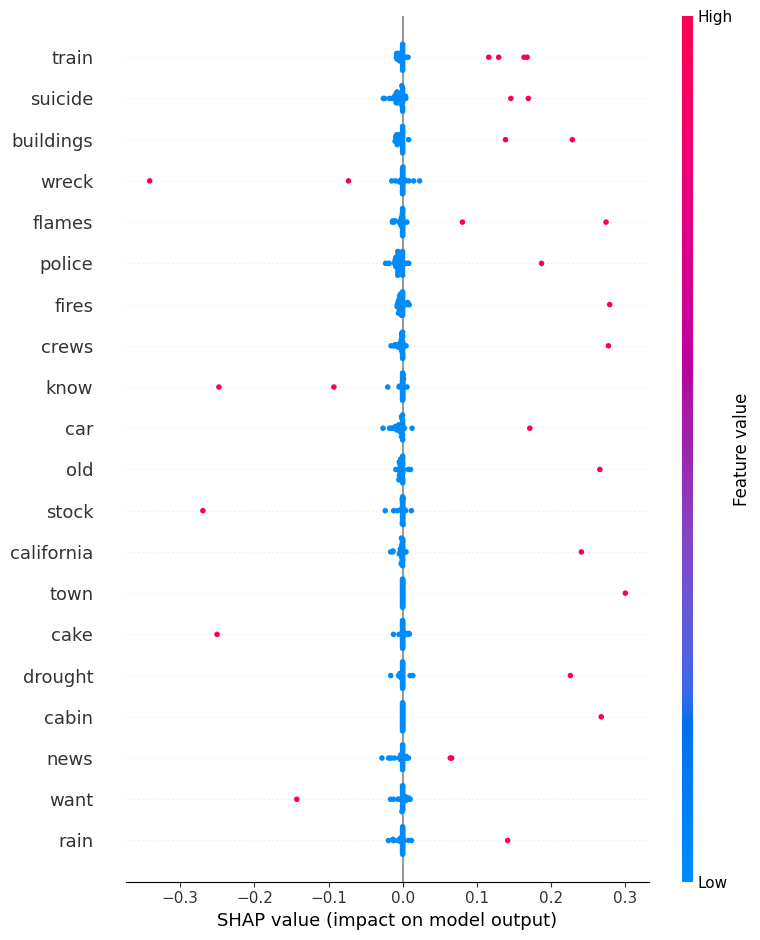

In [ ]:
shap.summary_plot(shap_vals, colour_test, feature_names=tf.get_feature_names_out())


In [ ]:

shap.force_plot(SHAP_explainer.expected_value, shap_vals[1,:],
                colour_test.iloc[1,:], feature_names=tf.get_feature_names_out())